El notebook desarrollado implementa dos enfoques de modelado para series de tiempo: modelos clásicos de suavización exponencial (ETS) y el modelo estructural Prophet. Para ambos métodos se incorporan técnicas avanzadas de optimización bayesiana mediante Optuna, lo que permite explorar de forma eficiente el espacio de hiperparámetros y seleccionar las configuraciones que minimizan el error de pronóstico. Además, la evaluación de desempeño se realiza utilizando dos estrategias robustas de validación temporal: la validación con ventana recurrente (expanding window), donde el conjunto de entrenamiento crece progresivamente en cada iteración, y la validación con ventana móvil (rolling window), en la que el tamaño del entrenamiento es fijo y se desplaza a lo largo de la serie. Estas metodologías garantizan una comparación justa, estable y realista de los modelos, permitiendo identificar aquel con mejor capacidad predictiva bajo condiciones similares a las del uso real.

In [721]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import optuna
import numpy as np
import pandas as pd
import warnings
import optuna
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose  # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
# Holwinters doble y tripe
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [722]:
# Carga de datos
# El archivo usa punto y coma como separador y coma como decimal
file_path = 'capacidad_acumulada_processed.csv'
df = pd.read_csv(file_path, sep=',', decimal='.')
df.tail()

,Fecha,SOLAR,EOLICA,PCH
77,2025-06-30,2905.793884,41.0,20.615945
78,2025-07-31,2907.402217,41.0,20.615945
79,2025-08-31,2909.382217,41.0,20.615945
80,2025-09-30,2909.382217,41.0,20.615945
81,2025-10-31,2909.382217,41.0,20.615945


In [723]:
#imputamos valores de las dos ultimas filas con valores publicacos en la web
df.loc[80] = ['2025-09-30', 3079, 41.00, 20.62]
#df.loc[81] = ['2025-10-31', 3120, 41.00, 20.62]
# Para eliminar por índice de fila y modificar el DataFrame original
df.drop(index=81, inplace=True)
df.tail(5)

,Fecha,SOLAR,EOLICA,PCH
76,2025-05-31,2904.185550,41.0,20.615945
77,2025-06-30,2905.793884,41.0,20.615945
78,2025-07-31,2907.402217,41.0,20.615945
79,2025-08-31,2909.382217,41.0,20.615945
80,2025-09-30,3079.000000,41.0,20.620000


In [724]:
df['Fecha'] = pd.to_datetime(df['Fecha'])   # convertir a fecha
df = df.set_index('Fecha')                  # usar como índice
df = df.asfreq('M')                         # asegurar frecuencia mensual

In [725]:
serie = df["SOLAR"].astype(float).sort_index()

In [726]:
serie.shape

(81,)

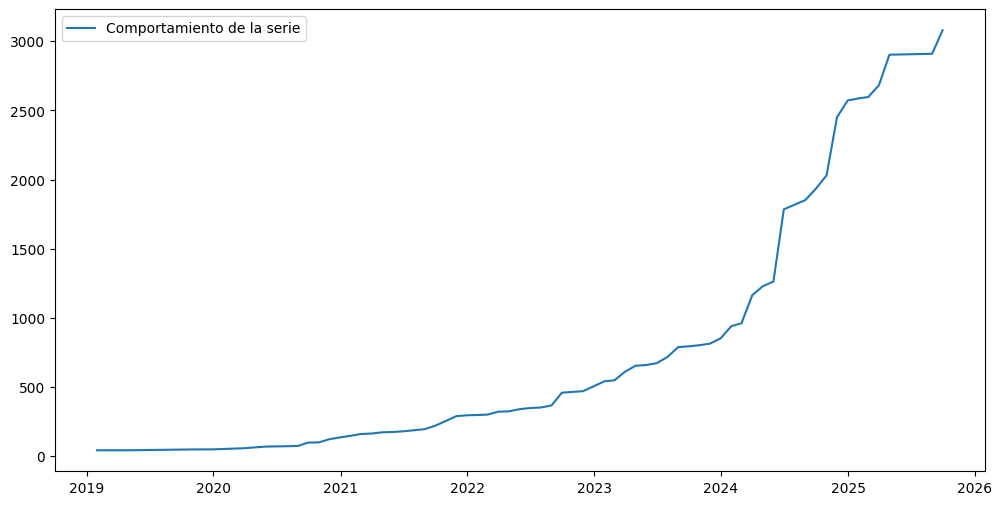

In [727]:
# visualizacion de los datos de la serie 
fig = plt.figure(figsize=(12, 6))
plt.plot(serie, label="Comportamiento de la serie")
plt.legend()
plt.show()

## **Función Entrenamiento ventana expandida y busqueda de mejores add, trend, seasonal, y sus respectivos Alpha, Beta y Gamma**

In [728]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")
import math
# definimos la funcion de optimizacion con los hiper paramatros. damped hace referencia a la amortiguacion de la tendencia 
def rolling_hw_rmse(serie,
                    horizon,
                    initial_train_size,
                    error,
                    trend,
                    seasonal,
                    seasonal_periods,
                    alpha,
                    beta,
                    gamma,
                    damped):
    
    y = np.asarray(serie.dropna())
    n = len(y)
    errors = []

    if n <= initial_train_size + horizon:
        return float("inf")

    for end in range(initial_train_size, n - horizon + 1):

        train = y[:end]
        test  = y[end:end + horizon]

        try:
            model = ExponentialSmoothing(
                train,
                trend=trend,
                damped_trend=damped,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                initialization_method="estimated",
            )
            
            fit = model.fit(
                optimized=True,
                smoothing_level=alpha,
                smoothing_slope=beta if trend is not None else None,
                smoothing_seasonal=gamma if seasonal is not None else None,
            )

            fcst = fit.forecast(horizon)

            rmse = np.sqrt(np.mean((fcst - test) ** 2))
            if not math.isfinite(rmse):
                return float("inf")

            errors.append(rmse)

        except Exception:
            return float("inf")

    return float(np.mean(errors)) if errors else float("inf")


## **Optimización Bayesiana**

In [729]:
H = 12  # horizonte de predicción

def objective(trial):

    # MODELOS
    trend = trial.suggest_categorical("trend", [None, "add", "mul"])
    seasonal = trial.suggest_categorical("seasonal", [None, "add", "mul"])

    seasonal_periods = None
    if seasonal is not None:
        seasonal_periods = trial.suggest_categorical("seasonal_periods", [6, 12])

    damped = trial.suggest_categorical("damped_trend", [False, True])

    # HIPERPARÁMETROS
    alpha = trial.suggest_float("alpha", 0.01, 0.99)
    beta  = trial.suggest_float("beta", 0.01, 0.99) if trend is not None else None
    gamma = trial.suggest_float("gamma", 0.01, 0.99) if seasonal is not None else None

    # tamaño inicial para ventana recursiva
    min_train = 36 if seasonal_periods is None else 3 * seasonal_periods

    rmse = rolling_hw_rmse(
        serie,
        horizon=H,
        initial_train_size=min_train,
        error=None,  # implícito por add/mul
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        damped=damped,
    )

    return rmse


In [730]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, n_jobs=1)

print("Mejor RMSE:", study.best_value)
print("Mejores parámetros:", study.best_params)


[I 2025-11-25 16:04:29,623] A new study created in memory with name: no-name-bc3a7e57-53bd-4179-a366-0e859ddd362c


[I 2025-11-25 16:04:29,835] Trial 0 finished with value: 785.7863629579127 and parameters: {'trend': None, 'seasonal': 'mul', 'seasonal_periods': 12, 'damped_trend': False, 'alpha': 0.037963590392334996, 'gamma': 0.3343759841194899}. Best is trial 0 with value: 785.7863629579127.
[I 2025-11-25 16:04:30,212] Trial 1 finished with value: 509.74726088012966 and parameters: {'trend': None, 'seasonal': 'add', 'seasonal_periods': 12, 'damped_trend': False, 'alpha': 0.7974928953492573, 'gamma': 0.4249511853447501}. Best is trial 1 with value: 509.74726088012966.
[I 2025-11-25 16:04:32,107] Trial 2 finished with value: 207.554893189217 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 6, 'damped_trend': True, 'alpha': 0.5327149504766314, 'beta': 0.3669330111896781, 'gamma': 0.7243783212182305}. Best is trial 2 with value: 207.554893189217.
[I 2025-11-25 16:04:36,864] Trial 3 finished with value: 289.72930468868964 and parameters: {'trend': 'add', 'seasonal': 'mul', 'seaso

Mejor RMSE: 193.84889909831566
Mejores parámetros: {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 6, 'damped_trend': False, 'alpha': 0.6761753172145993, 'beta': 0.2161715272807832, 'gamma': 0.2824154831283455}


## **Implementacion del modelo y pronostico de los 12 periodos**

In [731]:
best = study.best_params

trend = best["trend"]
seasonal = best["seasonal"]
damped = best["damped_trend"]
sp = best.get("seasonal_periods", None)

alpha = best["alpha"]
beta  = best.get("beta", None)
gamma = best.get("gamma", None)

model = ExponentialSmoothing(
    serie,
    trend=trend,
    damped_trend=damped,
    seasonal=seasonal,
    seasonal_periods=sp,
    initialization_method="estimated",
)

fit = model.fit(
    optimized=False,
    smoothing_level=alpha,
    smoothing_slope=beta if trend else None,
    smoothing_seasonal=gamma if seasonal else None,
)

forecast_12 = fit.forecast(12)
print(forecast_12)




2025-10-31    3205.624553
2025-11-30    3294.770147
2025-12-31    3457.436942
2026-01-31    3433.636263
2026-02-28    3384.625539
2026-03-31    3534.875757
2026-04-30    3682.686942
2026-05-31    3773.231744
2026-06-30    3947.655956
2026-07-31    3909.241560
2026-08-31    3842.863488
2026-09-30    4002.895088
Freq: ME, dtype: float64


## **funcion que utiliza bootstrap para generar intervalos de confianza**

In [ ]:
def bootstrap_hw_pi(fit, H, n_sim=1000, alpha=0.05, random_state=None):
    """
    Genera intervalos de predicción por bootstrap para un modelo Holt-Winters.

    Parámetros
    ----------
    fit : HoltWintersResults
        Objeto resultante de model.fit()
    H : int
        Horizonte de predicción (número de pasos hacia adelante)
    n_sim : int, opcional
        Número de simulaciones bootstrap
    alpha : float, opcional
        Nivel de significancia (0.05 -> intervalo 95%)
    random_state : int, opcional
        Semilla para reproducibilidad

    Retorna
    -------
    forecast : pd.Series
        Pronóstico puntual
    lower : pd.Series
        Límite inferior del intervalo
    upper : pd.Series
        Límite superior del intervalo
    """
    rng = np.random.default_rng(random_state)

    # Pronóstico puntual
    forecast = fit.forecast(H)

    # Residuos del modelo (errores in-sample)
    resid = fit.resid.dropna().values

    # Matriz de simulaciones: n_sim x H
    sim_paths = np.zeros((n_sim, H))

    for i in range(n_sim):
        # Muestra con reemplazo de residuos para cada horizonte
        errors = rng.choice(resid, size=H, replace=True)
        sim_paths[i, :] = forecast.values + errors

    # Percentiles empíricos para el intervalo (ej. 95%)
    lower = np.percentile(sim_paths, 100 * (alpha / 2), axis=0)
    upper = np.percentile(sim_paths, 100 * (1 - alpha / 2), axis=0)

    # Devolvemos como Series, preservando el índice del forecast
    lower = pd.Series(lower, index=forecast.index, name="lower")
    upper = pd.Series(upper, index=forecast.index, name="upper")

    return forecast, lower, upper


In [ ]:
# llamamos a la funcion para generar los intervalos de confianza 

H = 12  # horizonte de 12 pasos (por ejemplo, 12 meses)

forecast_12, lower_95_boot, upper_95_boot = bootstrap_hw_pi(
    fit,
    H=H,
    n_sim=1000,
    alpha=0.05,       # 95% de confianza
    random_state=42   # opcional, para reproducibilidad
)


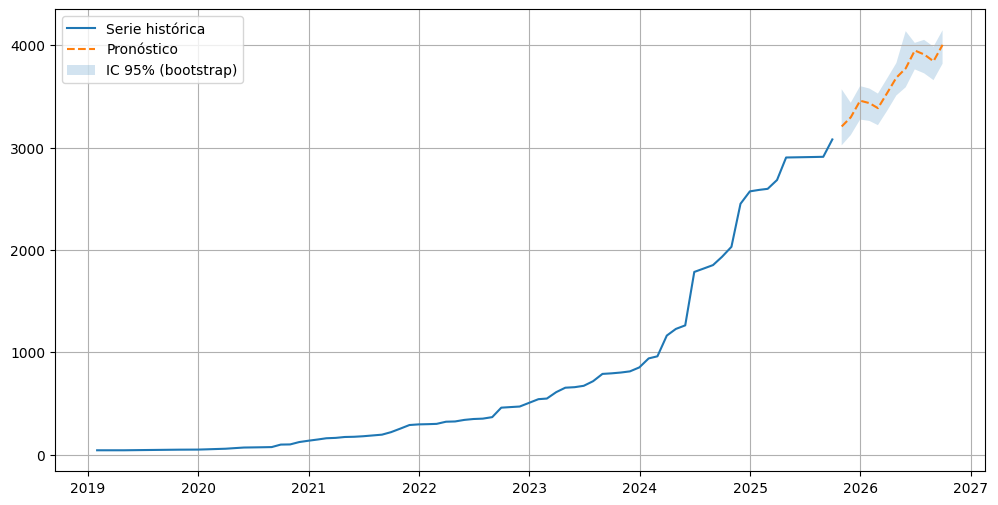

In [734]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(serie, label="Serie histórica")
plt.plot(forecast_12, label="Pronóstico", linestyle="--")
plt.fill_between(
    forecast_12.index,
    lower_95_boot,
    upper_95_boot,
    alpha=0.2,
    label="IC 95% (bootstrap)",
)
plt.legend()
plt.grid(True)
plt.show()


## **Función Entrenamiento ventana movil y busqueda de mejores add, trend, seasonal, y sus respectivos Alpha, Beta y Gamma**

In [ ]:
warnings.filterwarnings("ignore")
# definimos la funcion de optimizacion con los hiper paramatros. damped hace referencia a la amortiguacion de la tendencia 
def rmse_vec(a, b):
    return np.sqrt(np.mean((a - b)**2))

def moving_window_hw_rmse(serie,
                          horizon,
                          window_size,
                          trend,
                          seasonal,
                          seasonal_periods,
                          alpha,
                          beta,
                          gamma,
                          damped):

    y = np.asarray(serie.dropna())
    n = len(y)

    errors = []

    # Posiciones finales posibles de la ventana
    for start in range(0, n - window_size - horizon + 1):
        
        train = y[start : start + window_size]
        test  = y[start + window_size : start + window_size + horizon]

        try:
            model = ExponentialSmoothing(
                train,
                trend=trend,
                seasonal=seasonal,
                seasonal_periods=seasonal_periods,
                damped_trend=damped,
                initialization_method="estimated",
            )

            fit = model.fit(
                optimized=True,
                smoothing_level=alpha,
                smoothing_slope=beta if trend else None,
                smoothing_seasonal=gamma if seasonal else None
            )

            pred = fit.forecast(horizon)

            error = rmse_vec(pred, test)

            if not math.isfinite(error):
                return float("inf")

            errors.append(error)

        except Exception:
            return float("inf")

    if len(errors) == 0:
        return float("inf")

    return float(np.mean(errors))


## **Optimización Bayesiana**

In [ ]:
H = 12

def objective(trial):

    # MODELOS
    trend = trial.suggest_categorical("trend", [None, "add", "mul"])
    seasonal = trial.suggest_categorical("seasonal", [None, "add", "mul"])

    seasonal_periods = None
    if seasonal is not None:
        seasonal_periods = trial.suggest_categorical("seasonal_periods", [6, 12])

    damped = trial.suggest_categorical("damped", [False, True])

    # α β γ
    alpha = trial.suggest_float("alpha", 0.01, 0.99)
    beta  = trial.suggest_float("beta", 0.01, 0.99) if trend else None
    gamma = trial.suggest_float("gamma", 0.01, 0.99) if seasonal else None

    # Tamaño ventana móvil (36–82 meses)
    window_size = trial.suggest_int("window_size", 36, 82)
    #window_size = 80

    rmse = moving_window_hw_rmse(
        serie,
        horizon=H,
        window_size=window_size,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        damped=damped,
    )

    return rmse


In [739]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, n_jobs=1)

print("Mejor RMSE:", study.best_value)
print("Mejores parámetros:")
study.best_params


[I 2025-11-25 16:10:05,288] A new study created in memory with name: no-name-81e6a581-1f9f-4637-a7d2-44454d256dc0
[I 2025-11-25 16:10:05,291] Trial 0 finished with value: inf and parameters: {'trend': None, 'seasonal': 'mul', 'seasonal_periods': 6, 'damped': False, 'alpha': 0.9686138456835801, 'gamma': 0.4715643951016228, 'window_size': 91}. Best is trial 0 with value: inf.
[I 2025-11-25 16:10:05,295] Trial 1 finished with value: inf and parameters: {'trend': None, 'seasonal': None, 'damped': True, 'alpha': 0.4231529885249768, 'window_size': 79}. Best is trial 0 with value: inf.
[I 2025-11-25 16:10:05,372] Trial 2 finished with value: 706.4785903782288 and parameters: {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 6, 'damped': False, 'alpha': 0.10554202741819639, 'beta': 0.23541635643993675, 'gamma': 0.5170813267161766, 'window_size': 57}. Best is trial 2 with value: 706.4785903782288.
[I 2025-11-25 16:10:05,498] Trial 3 finished with value: 915.8658466603589 and parameters: {

Mejor RMSE: 292.1374419948889
Mejores parámetros:


{'trend': 'add',
 'seasonal': 'add',
 'seasonal_periods': 6,
 'damped': False,
 'alpha': 0.2588666547880359,
 'beta': 0.38693525544588536,
 'gamma': 0.7124142174604322,
 'window_size': 36}

## **Implementacion del modelo y pronostico de los 12 periodos**

In [740]:
best = study.best_params

trend   = best["trend"]
seasonal = best["seasonal"]
seasonal_periods = best.get("seasonal_periods", None)
damped = best["damped"]
alpha  = best["alpha"]
beta   = best.get("beta", None)
gamma  = best.get("gamma", None)

model = ExponentialSmoothing(
    serie,
    trend=trend,
    seasonal=seasonal,
    seasonal_periods=seasonal_periods,
    damped_trend=damped,
    initialization_method="estimated",
)

fit = model.fit(
    optimized=False,
    smoothing_level=alpha,
    smoothing_slope=beta if trend else None,
    smoothing_seasonal=gamma if seasonal else None,
)

forecast_12 = fit.forecast(H)
forecast_12


2025-10-31    3133.425182
2025-11-30    3138.406822
2025-12-31    3173.136192
2026-01-31    3203.784373
2026-02-28    3225.684413
2026-03-31    3308.914225
2026-04-30    3432.424887
2026-05-31    3437.406527
2026-06-30    3472.135897
2026-07-31    3502.784078
2026-08-31    3524.684118
2026-09-30    3607.913930
Freq: ME, dtype: float64

In [ ]:
# llamamos a la funcion para generar los intervalos de confianza
H = 12  # horizonte de 12 pasos (por ejemplo, 12 meses)

forecast_12, lower_95_boot, upper_95_boot = bootstrap_hw_pi(
    fit,
    H=H,
    n_sim=1000,
    alpha=0.05,       # 95% de confianza
    random_state=42   # opcional, para reproducibilidad
)

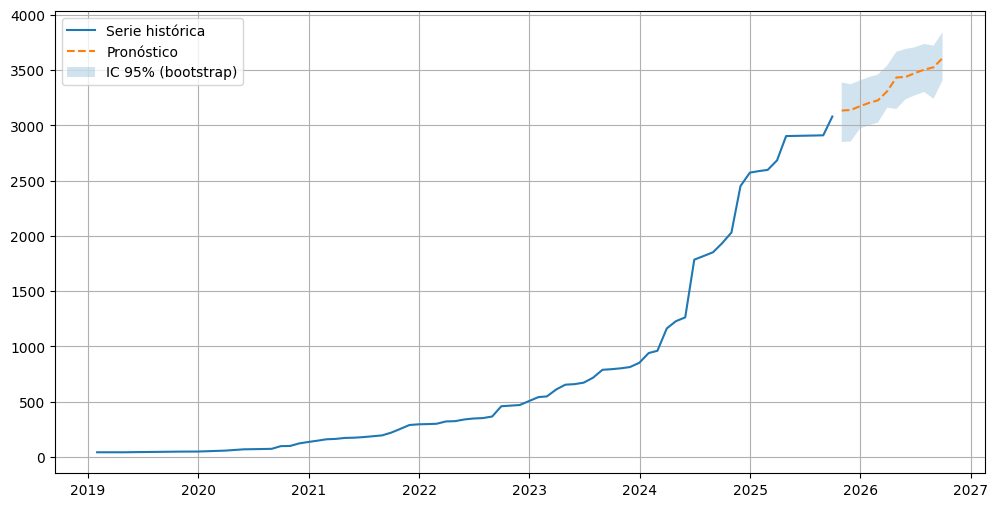

In [743]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(serie, label="Serie histórica")
plt.plot(forecast_12, label="Pronóstico", linestyle="--")
plt.fill_between(
    forecast_12.index,
    lower_95_boot,
    upper_95_boot,
    alpha=0.2,
    label="IC 95% (bootstrap)",
)
plt.legend()
plt.grid(True)
plt.show()

## **Implementacion del modelo PROPHET con ventana recursiva**

In [ ]:
solar = df.copy().reset_index()     # recuperamos la columna Fecha desde el índice
solar = solar.rename(columns={"Fecha": "ds", "SOLAR": "y"}) # se cambia el nombre ya que es necesario para utilizar el modelo 
solar = solar[["ds", "y"]]          # solo Prophet columns
solar["ds"] = pd.to_datetime(solar["ds"]) # se convierte en una serie de tiempo
solar = solar.sort_values("ds") #se ordena la columna 
solar.tail()

,ds,y
0,2019-01-31,42.539465
1,2019-02-28,42.539465
2,2019-03-31,42.539465
3,2019-04-30,42.539465
4,2019-05-31,43.595340


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from prophet import Prophet  

def rmse_expanding_prophet(
    df,                     # dataframe de entrada
    horizon=12,             # Número de pasos hacia adelante que quieres predecir en cada iteración.
    initial_window=24,   # Tamaño inicial del conjunto de entrenamiento.
    step_size=1,            #Controla cuántos pasos avanzas en el tiempo entre una ventana de validación y la siguiente.
    changepoint_prior_scale=0.05,   #Controla cuánta flexibilidad tiene el modelo para cambiar la tendencia (los “changepoints”). valor razonable por defecto
    seasonality_prior_scale=10.0,  #Controla la flexibilidad de la estacionalidad (por ejemplo, patrones anuales, mensuales).
    seasonality_mode="additive",    #Define cómo se combina la estacionalidad con la tendencia y el nivel:  y(t)=tendencia(t)+estacionalidad(t)+error
):
    """
    Valida un modelo Prophet para df (columnas ds, y) con
    ventana expandida y devuelve RMSE medio.
    """

    df = df.dropna().copy()     #Elimina cualquier fila que contenga valores NaN (vacíos o faltante
    n = len(df)                 #Guarda en n el número total de filas del DataFrame.
    rmses = []                  #Crea una lista vacía donde guardarás todos los valores de RMSE generados en cada ventana de validación.

    # índices donde termina el conjunto de entrenamiento
    for end_train in range(initial_window, n - horizon + 1, step_size): #genera una secuencia de índices end_train:
        train = df.iloc[:end_train]         #selecciona todas las filas desde el inicio hasta el índice
        test  = df.iloc[end_train:end_train + horizon] #Define el conjunto de prueba (test) para esa iteración.Empieza justo donde termina el train, en end_train.

        if len(test) < horizon:    #erifica que el conjunto de prueba tenga realmente el tamaño del horizonte.
            continue

        try:
            m = Prophet(                #se crea el modelo prophety todos sus hiperparametros
                changepoint_prior_scale=changepoint_prior_scale, #Controla la flexibilidad de la tendencia.
                seasonality_prior_scale=seasonality_prior_scale, #Controla cuánta flexibilidad tiene la estacionalidad para ajustarse a los datos.
                seasonality_mode=seasonality_mode, #cómo se combina la estacionalidad con la tendencia.
                yearly_seasonality=True,    #Activa estacionalidad anual (útil si tus datos son mensuales y hay patrones por año)
                weekly_seasonality=False,   #Desactiva estacionalidad semanal (no son relevantes si tus datos son mensuales).
                daily_seasonality=False,    #Desactivas estacionalidad diaria (no son relevantes si tus datos son mensuales).
            )

            # Puedes añadir más estacionalidades si lo necesitas:
            # m.add_seasonality(name="mensual", period=12, fourier_order=5)

            m.fit(train)                    #Ajusta  el modelo Prophet usando el conjunto de entrenamiento train.

            future = m.make_future_dataframe(periods=horizon, freq="M") #Crea un DataFrame con todas las fechas futuras que quieres predecir.
            forecast = m.predict(future)        #Genera la predicción completa de Prophet para:las fechas históricas (in-sample) y las fechas futuras (out-of-sample)

            # Tomamos solo los últimos 'horizon' pronósticos
            y_pred = forecast["yhat"].iloc[-horizon:].values    #Selecciona las últimas horizon filas de la columna yhat. Es decir, únicamente las predicciones futuras, NO las históricas.
            y_true = test["y"].values                       #Extrae del conjunto de prueba (test) los valores reales de la serie.

            rmse_fold = np.sqrt(mean_squared_error(y_true, y_pred)) #guarda el rmse en una ventana
            rmses.append(rmse_fold)

        except Exception:
            # si algo explota, penalizamos
            return np.inf

    if not rmses:
        return np.inf

    return float(np.mean(rmses))


In [ ]:
import optuna

def objective(trial):
    # Espacio de búsqueda de hiperparámetros
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 0.5, log=True) #Controla cuánta flexibilidad tiene la tendencia para cambiar.
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 1.0, 40.0, log=True) #Controla la flexibilidad de la estacionalidad.
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"]) # busca si es modo aditivo o multiplicativo

    rmse = rmse_expanding_prophet(              #entrena varios modelos Prophet usando ventana expandida,
        df=solar,                           
        horizon=12,                 #En cada iteración, predice 12 pasos hacia adelante     
        initial_window=24,           #“La primera vez, entrena el modelo con 24 filas (por ejemplo meses)”
        step_size=1,                #Esto define cuánto avanza la ventana en cada iteración.
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )

    return rmse

study = optuna.create_study(direction="minimize") #crea un objeto "Study", que es donde Optuna guarda:los resultados de cada prueba,, los mejores hiperparámetros encontrados,, rmse
study.optimize(objective, n_trials=30)   # puedes subir n_trials si tienes tiempo
print("Mejor RMSE:", study.best_value)
print("Mejores hiperparámetros:", study.best_params)


[I 2025-11-25 13:28:13,709] A new study created in memory with name: no-name-79a22fa1-bb44-4e76-aa4f-762281e6c97b
13:28:13 - cmdstanpy - INFO - Chain [1] start processing
13:28:13 - cmdstanpy - INFO - Chain [1] done processing
13:28:13 - cmdstanpy - INFO - Chain [1] start processing
13:28:14 - cmdstanpy - INFO - Chain [1] done processing
13:28:14 - cmdstanpy - INFO - Chain [1] start processing
13:28:14 - cmdstanpy - INFO - Chain [1] done processing
13:28:14 - cmdstanpy - INFO - Chain [1] start processing
13:28:14 - cmdstanpy - INFO - Chain [1] done processing
13:28:14 - cmdstanpy - INFO - Chain [1] start processing
13:28:14 - cmdstanpy - INFO - Chain [1] done processing
13:28:14 - cmdstanpy - INFO - Chain [1] start processing
13:28:14 - cmdstanpy - INFO - Chain [1] done processing
13:28:15 - cmdstanpy - INFO - Chain [1] start processing
13:28:15 - cmdstanpy - INFO - Chain [1] done processing
13:28:15 - cmdstanpy - INFO - Chain [1] start processing
13:28:15 - cmdstanpy - INFO - Chain [1

Mejor RMSE: 264.0747111121385
Mejores hiperparámetros: {'changepoint_prior_scale': 0.46398870732480396, 'seasonality_prior_scale': 1.8729078474865535, 'seasonality_mode': 'additive'}


In [81]:
best_params = study.best_params

m_final = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
    seasonality_mode=best_params["seasonality_mode"],
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

# de nuevo, puedes añadir estacionalidad mensual explícita si lo deseas:
# m_final.add_seasonality(name="mensual", period=12, fourier_order=5)

m_final.fit(solar)

# Pronóstico de los próximos 12 meses
future = m_final.make_future_dataframe(periods=12, freq="M")
forecast = m_final.predict(future)

# Extraemos solo los 12 periodos futuros
forecast_12 = forecast.tail(12)[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_12


14:27:13 - cmdstanpy - INFO - Chain [1] start processing
14:27:14 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
81,2025-10-31,3400.575424,3305.302525,3495.631512
82,2025-11-30,3588.756134,3491.947373,3680.809708
83,2025-12-31,3702.002989,3610.967950,3799.444239
84,2026-01-31,3792.962648,3689.757948,3893.042427
85,2026-02-28,3873.156571,3777.284524,3969.970680
86,2026-03-31,3986.823568,3882.946896,4088.743538
87,2026-04-30,4099.726302,3985.783241,4210.382471
88,2026-05-31,4184.551425,4068.148556,4299.581949
89,2026-06-30,4300.080869,4173.889536,4413.760636
90,2026-07-31,4400.207557,4278.549226,4528.016824


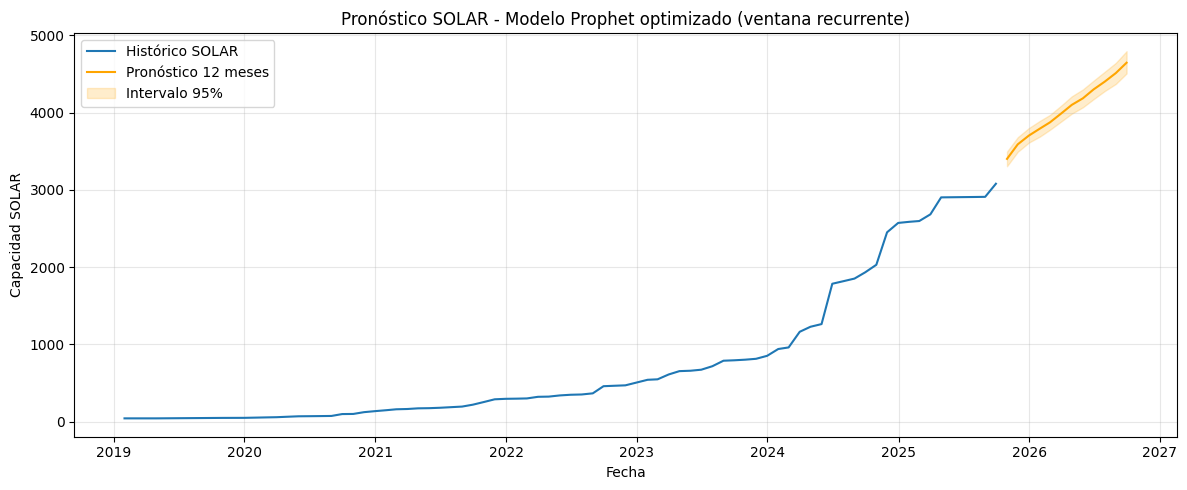

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# histórico
plt.plot(solar["ds"], solar["y"], label="Histórico SOLAR")

# pronóstico (últimos 12 puntos)
plt.plot(forecast_12["ds"], forecast_12["yhat"], color="orange", label="Pronóstico 12 meses")

# banda de confianza
plt.fill_between(
    forecast_12["ds"],
    forecast_12["yhat_lower"],
    forecast_12["yhat_upper"],
    color="orange",
    alpha=0.2,
    label="Intervalo 95%"
)

plt.xlabel("Fecha")
plt.ylabel("Capacidad SOLAR")
plt.title("Pronóstico SOLAR - Modelo Prophet optimizado (ventana recurrente)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## **Implementacion del modelo PROPHET con ventana movil**

In [ ]:
def rmse_rolling_prophet(
    df,
    horizon=12,
    window_size=36,     # tamaño fijo de ventana
    step_size=1,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    seasonality_mode="additive",
):
    """
    Validación con ventana móvil (rolling window) para Prophet.
   
    """

    df = df.dropna().copy()
    n = len(df)
    rmses = []

    for start in range(0, n - window_size - horizon + 1, step_size):

        end_train = start + window_size
        train = df.iloc[start:end_train]
        test  = df.iloc[end_train:end_train + horizon]

        if len(test) < horizon:
            continue

        try:
            m = Prophet(
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,
                seasonality_mode=seasonality_mode,
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
            )

            # Ejemplo: estacionalidad mensual adicional
            # m.add_seasonality(name="mensual", period=12, fourier_order=5)

            m.fit(train)

            future = m.make_future_dataframe(periods=horizon, freq="M")
            forecast = m.predict(future)

            y_pred = forecast["yhat"].iloc[-horizon:].values
            y_true = test["y"].values

            rmse_fold = np.sqrt(mean_squared_error(y_true, y_pred))
            rmses.append(rmse_fold)

        except Exception:
            return np.inf

    if not rmses:
        return np.inf

    return float(np.mean(rmses))


In [746]:
from optuna.samplers import TPESampler

H = 12          # horizonte de pronóstico
WINDOW = 36     # tamaño de ventana fija (36 meses ~ 3 años)

def objective(trial):
    # Hiperparámetros de Prophet a optimizar
    changepoint_prior_scale = trial.suggest_float(
        "changepoint_prior_scale", 0.001, 0.5, log=True
    )
    seasonality_prior_scale = trial.suggest_float(
        "seasonality_prior_scale", 0.1, 20.0, log=True
    )
    seasonality_mode = trial.suggest_categorical(
        "seasonality_mode", ["additive", "multiplicative"]
    )

    # Si quieres, podrías optimizar también horizon/window_size,
    # pero es mejor mantenerlos fijos para comparar.

    rmse = rmse_rolling_prophet(
        df=solar,                    # tu DataFrame con columnas ds, y
        horizon=H,
        window_size=WINDOW,
        step_size=1,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )

    return rmse


In [747]:
sampler = TPESampler(seed=42)  # para reproducibilidad
study = optuna.create_study(direction="minimize", sampler=sampler)

study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Mejor RMSE:", study.best_value)
print("Mejores parámetros:", study.best_params)


[I 2025-11-25 16:31:38,567] A new study created in memory with name: no-name-e16f5a1d-9341-4a2c-81ef-a77d4cb528ff
  0%|          | 0/50 [00:00<?, ?it/s]16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:31:40 - cmdstanpy - INFO - Chain [1] done processing
16:31:40 - cmdstanpy - INFO - Chain [1] start processing
16:31:40 - cmdstanpy - INFO - Chain [1] done processing
16:31:40 - cmdstanpy - INFO - Chain [1] start processing
16:31:40 - cmdstanpy - INFO - Chain [1] done processing
16:31:40 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-11-25 16:31:47,637] Trial 0 finished with value: 517.7205910444387 and parameters: {'changepoint_prior_scale': 0.010253509690168494, 'seasonality_prior_scale': 15.40359659501924, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 517.7205910444387.


16:31:47 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1] done processing
16:31:49 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1] done processing
16:31:49 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1] done processing
16:31:49 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1]

[I 2025-11-25 16:31:55,331] Trial 1 finished with value: 505.9449553129119 and parameters: {'changepoint_prior_scale': 0.0026368755339723046, 'seasonality_prior_scale': 0.22853255256339208, 'seasonality_mode': 'multiplicative'}. Best is trial 1 with value: 505.9449553129119.


16:31:55 - cmdstanpy - INFO - Chain [1] done processing
16:31:55 - cmdstanpy - INFO - Chain [1] start processing
16:31:56 - cmdstanpy - INFO - Chain [1] done processing
16:31:56 - cmdstanpy - INFO - Chain [1] start processing
16:31:56 - cmdstanpy - INFO - Chain [1] done processing
16:31:56 - cmdstanpy - INFO - Chain [1] start processing
16:31:56 - cmdstanpy - INFO - Chain [1] done processing
16:31:56 - cmdstanpy - INFO - Chain [1] start processing
16:31:57 - cmdstanpy - INFO - Chain [1] done processing
16:31:57 - cmdstanpy - INFO - Chain [1] start processing
16:31:57 - cmdstanpy - INFO - Chain [1] done processing
16:31:57 - cmdstanpy - INFO - Chain [1] start processing
16:31:57 - cmdstanpy - INFO - Chain [1] done processing
16:31:57 - cmdstanpy - INFO - Chain [1] start processing
16:31:58 - cmdstanpy - INFO - Chain [1] done processing
16:31:58 - cmdstanpy - INFO - Chain [1] start processing
16:31:58 - cmdstanpy - INFO - Chain [1] done processing
16:31:58 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 16:32:06,818] Trial 2 finished with value: 365.58986677553145 and parameters: {'changepoint_prior_scale': 0.041917115166952006, 'seasonality_prior_scale': 4.258888210290081, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 365.58986677553145.


16:32:07 - cmdstanpy - INFO - Chain [1] done processing
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing
16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:22 - cmdstanpy - INFO - Chain [1] done processing
16:32:22 - cmdstanpy - INFO - Chain [1] start processing
16:32:22 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:37 - cmdstanpy - INFO - Chain [1] done processing
16:32:37 - cmdstanpy - INFO - Chain [1] start processing
16:33:07 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:52 - cmdstanpy - INFO - Chain [1] done processing
16:33:53 - cmdstanpy - INFO - Chain [1] start processing
16:34:39 - cmdstanpy - INFO - Chain [1] done processing
16:34:39 - cmdstanpy - INFO - Chain [1] start processing
16:35:29 - cmdstanpy - INFO - Chain [1] done processing
16:35:29 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 16:39:59,170] Trial 3 finished with value: 335.8447802604391 and parameters: {'changepoint_prior_scale': 0.1764971584817571, 'seasonality_prior_scale': 0.30803400529839686, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


16:39:59 - cmdstanpy - INFO - Chain [1] start processing
16:39:59 - cmdstanpy - INFO - Chain [1] done processing
16:39:59 - cmdstanpy - INFO - Chain [1] start processing
16:39:59 - cmdstanpy - INFO - Chain [1] done processing
16:39:59 - cmdstanpy - INFO - Chain [1] start processing
16:39:59 - cmdstanpy - INFO - Chain [1] done processing
16:40:00 - cmdstanpy - INFO - Chain [1] start processing
16:40:00 - cmdstanpy - INFO - Chain [1] done processing
16:40:00 - cmdstanpy - INFO - Chain [1] start processing
16:40:00 - cmdstanpy - INFO - Chain [1] done processing
16:40:00 - cmdstanpy - INFO - Chain [1] start processing
16:40:00 - cmdstanpy - INFO - Chain [1] done processing
16:40:00 - cmdstanpy - INFO - Chain [1] start processing
16:40:00 - cmdstanpy - INFO - Chain [1] done processing
16:40:00 - cmdstanpy - INFO - Chain [1] start processing
16:40:01 - cmdstanpy - INFO - Chain [1] done processing
16:40:01 - cmdstanpy - INFO - Chain [1] start processing
16:40:01 - cmdstanpy - INFO - Chain [1]

[I 2025-11-25 16:40:06,751] Trial 4 finished with value: 517.0109934341533 and parameters: {'changepoint_prior_scale': 0.006624310605949983, 'seasonality_prior_scale': 1.6124278458562613, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 335.8447802604391.


16:40:07 - cmdstanpy - INFO - Chain [1] done processing
16:40:07 - cmdstanpy - INFO - Chain [1] start processing
16:40:07 - cmdstanpy - INFO - Chain [1] done processing
16:40:07 - cmdstanpy - INFO - Chain [1] start processing
16:40:07 - cmdstanpy - INFO - Chain [1] done processing
16:40:07 - cmdstanpy - INFO - Chain [1] start processing
16:40:08 - cmdstanpy - INFO - Chain [1] done processing
16:40:08 - cmdstanpy - INFO - Chain [1] start processing
16:40:08 - cmdstanpy - INFO - Chain [1] done processing
16:40:08 - cmdstanpy - INFO - Chain [1] start processing
16:40:08 - cmdstanpy - INFO - Chain [1] done processing
16:40:08 - cmdstanpy - INFO - Chain [1] start processing
16:40:09 - cmdstanpy - INFO - Chain [1] done processing
16:40:09 - cmdstanpy - INFO - Chain [1] start processing
16:40:09 - cmdstanpy - INFO - Chain [1] done processing
16:40:09 - cmdstanpy - INFO - Chain [1] start processing
16:40:09 - cmdstanpy - INFO - Chain [1] done processing
16:40:09 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 16:40:17,980] Trial 5 finished with value: 349.1936014550579 and parameters: {'changepoint_prior_scale': 0.044809759182149515, 'seasonality_prior_scale': 0.20940138873937433, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


16:40:18 - cmdstanpy - INFO - Chain [1] done processing
16:40:18 - cmdstanpy - INFO - Chain [1] start processing
16:40:18 - cmdstanpy - INFO - Chain [1] done processing
16:40:18 - cmdstanpy - INFO - Chain [1] start processing
16:40:18 - cmdstanpy - INFO - Chain [1] done processing
16:40:18 - cmdstanpy - INFO - Chain [1] start processing
16:40:19 - cmdstanpy - INFO - Chain [1] done processing
16:40:19 - cmdstanpy - INFO - Chain [1] start processing
16:40:19 - cmdstanpy - INFO - Chain [1] done processing
16:40:19 - cmdstanpy - INFO - Chain [1] start processing
16:40:19 - cmdstanpy - INFO - Chain [1] done processing
16:40:19 - cmdstanpy - INFO - Chain [1] start processing
16:40:19 - cmdstanpy - INFO - Chain [1] done processing
16:40:19 - cmdstanpy - INFO - Chain [1] start processing
16:40:20 - cmdstanpy - INFO - Chain [1] done processing
16:40:20 - cmdstanpy - INFO - Chain [1] start processing
16:40:20 - cmdstanpy - INFO - Chain [1] done processing
16:40:20 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 16:40:27,860] Trial 6 finished with value: 535.3045644204327 and parameters: {'changepoint_prior_scale': 0.01701841881702917, 'seasonality_prior_scale': 6.407866261851015, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


16:40:28 - cmdstanpy - INFO - Chain [1] start processing
16:40:28 - cmdstanpy - INFO - Chain [1] done processing
16:40:28 - cmdstanpy - INFO - Chain [1] start processing
16:40:28 - cmdstanpy - INFO - Chain [1] done processing
16:40:28 - cmdstanpy - INFO - Chain [1] start processing
16:40:28 - cmdstanpy - INFO - Chain [1] done processing
16:40:28 - cmdstanpy - INFO - Chain [1] start processing
16:40:29 - cmdstanpy - INFO - Chain [1] done processing
16:40:29 - cmdstanpy - INFO - Chain [1] start processing
16:40:29 - cmdstanpy - INFO - Chain [1] done processing
16:40:29 - cmdstanpy - INFO - Chain [1] start processing
16:40:29 - cmdstanpy - INFO - Chain [1] done processing
16:40:29 - cmdstanpy - INFO - Chain [1] start processing
16:40:29 - cmdstanpy - INFO - Chain [1] done processing
16:40:29 - cmdstanpy - INFO - Chain [1] start processing
16:40:30 - cmdstanpy - INFO - Chain [1] done processing
16:40:30 - cmdstanpy - INFO - Chain [1] start processing
16:40:30 - cmdstanpy - INFO - Chain [1]

[I 2025-11-25 16:40:37,599] Trial 7 finished with value: 416.11144322234077 and parameters: {'changepoint_prior_scale': 0.039710847107924725, 'seasonality_prior_scale': 0.12790390175145838, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 335.8447802604391.


16:40:38 - cmdstanpy - INFO - Chain [1] done processing
16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:38 - cmdstanpy - INFO - Chain [1] done processing
16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:38 - cmdstanpy - INFO - Chain [1] done processing
16:40:38 - cmdstanpy - INFO - Chain [1] start processing
16:40:38 - cmdstanpy - INFO - Chain [1] done processing
16:40:39 - cmdstanpy - INFO - Chain [1] start processing
16:40:39 - cmdstanpy - INFO - Chain [1] done processing
16:40:39 - cmdstanpy - INFO - Chain [1] start processing
16:40:39 - cmdstanpy - INFO - Chain [1] done processing
16:40:39 - cmdstanpy - INFO - Chain [1] start processing
16:40:39 - cmdstanpy - INFO - Chain [1] done processing
16:40:39 - cmdstanpy - INFO - Chain [1] start processing
16:40:40 - cmdstanpy - INFO - Chain [1] done processing
16:40:40 - cmdstanpy - INFO - Chain [1] start processing
16:40:40 - cmdstanpy - INFO - Chain [1] done processing
16:40:40 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 16:40:46,792] Trial 8 finished with value: 517.7476666280578 and parameters: {'changepoint_prior_scale': 0.0014982086432155466, 'seasonality_prior_scale': 15.255065745117381, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 335.8447802604391.


16:40:47 - cmdstanpy - INFO - Chain [1] start processing
16:40:47 - cmdstanpy - INFO - Chain [1] done processing
16:40:47 - cmdstanpy - INFO - Chain [1] start processing
16:40:47 - cmdstanpy - INFO - Chain [1] done processing
16:40:47 - cmdstanpy - INFO - Chain [1] start processing
16:40:47 - cmdstanpy - INFO - Chain [1] done processing
16:40:47 - cmdstanpy - INFO - Chain [1] start processing
16:40:47 - cmdstanpy - INFO - Chain [1] done processing
16:40:47 - cmdstanpy - INFO - Chain [1] start processing
16:40:48 - cmdstanpy - INFO - Chain [1] done processing
16:40:48 - cmdstanpy - INFO - Chain [1] start processing
16:40:48 - cmdstanpy - INFO - Chain [1] done processing
16:40:48 - cmdstanpy - INFO - Chain [1] start processing
16:40:48 - cmdstanpy - INFO - Chain [1] done processing
16:40:48 - cmdstanpy - INFO - Chain [1] start processing
16:40:48 - cmdstanpy - INFO - Chain [1] done processing
16:40:48 - cmdstanpy - INFO - Chain [1] start processing
16:40:48 - cmdstanpy - INFO - Chain [1]

[I 2025-11-25 16:40:54,498] Trial 9 finished with value: 506.55909231586935 and parameters: {'changepoint_prior_scale': 0.00663962307985946, 'seasonality_prior_scale': 0.1677824238407793, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 335.8447802604391.


16:41:09 - cmdstanpy - INFO - Chain [1] done processing
16:41:09 - cmdstanpy - INFO - Chain [1] start processing
16:41:24 - cmdstanpy - INFO - Chain [1] done processing
16:41:25 - cmdstanpy - INFO - Chain [1] start processing
16:41:39 - cmdstanpy - INFO - Chain [1] done processing
16:41:39 - cmdstanpy - INFO - Chain [1] start processing
16:41:54 - cmdstanpy - INFO - Chain [1] done processing
16:41:54 - cmdstanpy - INFO - Chain [1] start processing
16:42:09 - cmdstanpy - INFO - Chain [1] done processing
16:42:09 - cmdstanpy - INFO - Chain [1] start processing
16:42:24 - cmdstanpy - INFO - Chain [1] done processing
16:42:24 - cmdstanpy - INFO - Chain [1] start processing
16:42:39 - cmdstanpy - INFO - Chain [1] done processing
16:42:39 - cmdstanpy - INFO - Chain [1] start processing
16:42:54 - cmdstanpy - INFO - Chain [1] done processing
16:42:54 - cmdstanpy - INFO - Chain [1] start processing
16:43:09 - cmdstanpy - INFO - Chain [1] done processing
16:43:09 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 16:49:31,341] Trial 10 finished with value: 335.92541945682626 and parameters: {'changepoint_prior_scale': 0.3555454971866563, 'seasonality_prior_scale': 0.6869866335896525, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


16:49:46 - cmdstanpy - INFO - Chain [1] done processing
16:49:46 - cmdstanpy - INFO - Chain [1] start processing
16:50:01 - cmdstanpy - INFO - Chain [1] done processing
16:50:01 - cmdstanpy - INFO - Chain [1] start processing
16:50:24 - cmdstanpy - INFO - Chain [1] done processing
16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:51:02 - cmdstanpy - INFO - Chain [1] done processing
16:51:03 - cmdstanpy - INFO - Chain [1] start processing
16:51:39 - cmdstanpy - INFO - Chain [1] done processing
16:51:40 - cmdstanpy - INFO - Chain [1] start processing
16:51:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:13 - cmdstanpy - INFO - Chain [1] done processing
16:52:14 - cmdstanpy - INFO - Chain [1] start processing
16:52:28 - cmdstanpy - INFO - Chain [1] done processing
16:52:28 - cmdstanpy - INFO - Chain [1] start processing
16:52:43 - cmdstanpy - INFO - Chain [1] done processing
16:52:43 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 17:04:23,588] Trial 11 finished with value: 341.4780689355684 and parameters: {'changepoint_prior_scale': 0.37252049973608903, 'seasonality_prior_scale': 0.6255147374803773, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


17:04:23 - cmdstanpy - INFO - Chain [1] start processing
17:05:15 - cmdstanpy - INFO - Chain [1] done processing
17:05:15 - cmdstanpy - INFO - Chain [1] start processing
17:06:05 - cmdstanpy - INFO - Chain [1] done processing
17:06:05 - cmdstanpy - INFO - Chain [1] start processing
17:06:58 - cmdstanpy - INFO - Chain [1] done processing
17:06:58 - cmdstanpy - INFO - Chain [1] start processing
17:07:47 - cmdstanpy - INFO - Chain [1] done processing
17:07:47 - cmdstanpy - INFO - Chain [1] start processing
17:08:34 - cmdstanpy - INFO - Chain [1] done processing
17:08:34 - cmdstanpy - INFO - Chain [1] start processing
17:09:21 - cmdstanpy - INFO - Chain [1] done processing
17:09:22 - cmdstanpy - INFO - Chain [1] start processing
17:10:10 - cmdstanpy - INFO - Chain [1] done processing
17:10:11 - cmdstanpy - INFO - Chain [1] start processing
17:10:59 - cmdstanpy - INFO - Chain [1] done processing
17:10:59 - cmdstanpy - INFO - Chain [1] start processing
17:11:58 - cmdstanpy - INFO - Chain [1]

[I 2025-11-25 17:39:18,230] Trial 12 finished with value: 338.1259513686999 and parameters: {'changepoint_prior_scale': 0.4583642850410267, 'seasonality_prior_scale': 0.676156773061676, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


17:39:18 - cmdstanpy - INFO - Chain [1] done processing
17:39:18 - cmdstanpy - INFO - Chain [1] start processing
17:39:19 - cmdstanpy - INFO - Chain [1] done processing
17:39:19 - cmdstanpy - INFO - Chain [1] start processing
17:39:33 - cmdstanpy - INFO - Chain [1] done processing
17:39:33 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:35 - cmdstanpy - INFO - Chain [1] done processing
17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:50 - cmdstanpy - INFO - Chain [1] done processing
17:39:50 - cmdstanpy - INFO - Chain [1] start processing
17:40:04 - cmdstanpy - INFO - Chain [1] done processing
17:40:04 - cmdstanpy - INFO - Chain [1] start processing
17:40:08 - cmdstanpy - INFO - Chain [1] done processing
17:40:08 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 17:43:40,169] Trial 13 finished with value: 345.1933541394003 and parameters: {'changepoint_prior_scale': 0.16240855387856246, 'seasonality_prior_scale': 0.5927330996383823, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


17:43:40 - cmdstanpy - INFO - Chain [1] done processing
17:43:40 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:42 - cmdstanpy - INFO - Chain [1] done processing
17:43:42 - cmdstanpy - INFO - Chain [1] start processing
17:43:42 - cmdstanpy - INFO - Chain [1] done processing
17:43:42 - cmdstanpy - INFO - Chain [1] start processing
17:43:43 - cmdstanpy - INFO - Chain [1] done processing
17:43:43 - cmdstanpy - INFO - Chain [1] start processing
17:43:58 - cmdstanpy - INFO - Chain [1] done processing
17:43:58 - cmdstanpy - INFO - Chain [1] start processing
17:43:58 - cmdstanpy - INFO - Chain [1] done processing
17:43:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 17:46:51,693] Trial 14 finished with value: 345.25277914278706 and parameters: {'changepoint_prior_scale': 0.1427287262051746, 'seasonality_prior_scale': 1.7079985511440505, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


17:46:52 - cmdstanpy - INFO - Chain [1] done processing
17:46:52 - cmdstanpy - INFO - Chain [1] start processing
17:46:52 - cmdstanpy - INFO - Chain [1] done processing
17:46:52 - cmdstanpy - INFO - Chain [1] start processing
17:46:53 - cmdstanpy - INFO - Chain [1] done processing
17:46:53 - cmdstanpy - INFO - Chain [1] start processing
17:46:53 - cmdstanpy - INFO - Chain [1] done processing
17:46:53 - cmdstanpy - INFO - Chain [1] start processing
17:46:53 - cmdstanpy - INFO - Chain [1] done processing
17:46:54 - cmdstanpy - INFO - Chain [1] start processing
17:46:54 - cmdstanpy - INFO - Chain [1] done processing
17:46:54 - cmdstanpy - INFO - Chain [1] start processing
17:46:54 - cmdstanpy - INFO - Chain [1] done processing
17:46:54 - cmdstanpy - INFO - Chain [1] start processing
17:46:55 - cmdstanpy - INFO - Chain [1] done processing
17:46:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:10 - cmdstanpy - INFO - Chain [1] done processing
17:47:10 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 17:49:38,892] Trial 15 finished with value: 340.0788149945797 and parameters: {'changepoint_prior_scale': 0.1323098654296562, 'seasonality_prior_scale': 0.3751111516906678, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


17:49:53 - cmdstanpy - INFO - Chain [1] done processing
17:49:53 - cmdstanpy - INFO - Chain [1] start processing
17:50:08 - cmdstanpy - INFO - Chain [1] done processing
17:50:08 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing
17:50:23 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing
17:50:48 - cmdstanpy - INFO - Chain [1] start processing
17:51:35 - cmdstanpy - INFO - Chain [1] done processing
17:51:36 - cmdstanpy - INFO - Chain [1] start processing
17:52:23 - cmdstanpy - INFO - Chain [1] done processing
17:52:23 - cmdstanpy - INFO - Chain [1] start processing
17:53:10 - cmdstanpy - INFO - Chain [1] done processing
17:53:10 - cmdstanpy - INFO - Chain [1] start processing
17:53:57 - cmdstanpy - INFO - Chain [1] done processing
17:53:58 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:08:51,138] Trial 16 finished with value: 340.2179163085739 and parameters: {'changepoint_prior_scale': 0.2323296010309177, 'seasonality_prior_scale': 0.9749348999354988, 'seasonality_mode': 'multiplicative'}. Best is trial 3 with value: 335.8447802604391.


18:08:51 - cmdstanpy - INFO - Chain [1] start processing
18:08:52 - cmdstanpy - INFO - Chain [1] done processing
18:08:52 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:55 - cmdstanpy - INFO - Chain [1] done processing
18:08:56 - cmdstanpy - INFO - Chain [1] start processing
18:08:57 - cmdstanpy - INFO - Chain [1] done processing
18:08:57 - cmdstanpy - INFO - Chain [1] start processing
18:08:58 - cmdstanpy - INFO - Chain [1] done processing
18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:08:59 - cmdstanpy - INFO - Chain [1] done processing
18:09:00 - cmdstanpy - INFO - Chain [1] start processing
18:09:01 - cmdstanpy - INFO - Chain [1] done processing
18:09:01 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1]

[I 2025-11-25 18:09:31,820] Trial 17 finished with value: 333.25436089359374 and parameters: {'changepoint_prior_scale': 0.07261705019895937, 'seasonality_prior_scale': 0.35576596992563525, 'seasonality_mode': 'multiplicative'}. Best is trial 17 with value: 333.25436089359374.


18:09:33 - cmdstanpy - INFO - Chain [1] done processing
18:09:33 - cmdstanpy - INFO - Chain [1] start processing
18:09:34 - cmdstanpy - INFO - Chain [1] done processing
18:09:34 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:36 - cmdstanpy - INFO - Chain [1] start processing
18:09:36 - cmdstanpy - INFO - Chain [1] done processing
18:09:37 - cmdstanpy - INFO - Chain [1] start processing
18:09:38 - cmdstanpy - INFO - Chain [1] done processing
18:09:38 - cmdstanpy - INFO - Chain [1] start processing
18:09:39 - cmdstanpy - INFO - Chain [1] done processing
18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:40 - cmdstanpy - INFO - Chain [1] done processing
18:09:41 - cmdstanpy - INFO - Chain [1] start processing
18:09:42 - cmdstanpy - INFO - Chain [1] done processing
18:09:42 - cmdstanpy - INFO - Chain [1] start processing
18:09:44 - cmdstanpy - INFO - Chain [1] done processing
18:09:44 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:10:14,253] Trial 18 finished with value: 336.33350731083823 and parameters: {'changepoint_prior_scale': 0.07805789099500486, 'seasonality_prior_scale': 0.33294756390931574, 'seasonality_mode': 'multiplicative'}. Best is trial 17 with value: 333.25436089359374.


18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:17 - cmdstanpy - INFO - Chain [1] done processing
18:10:18 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing
18:10:19 - cmdstanpy - INFO - Chain [1] start processing
18:10:20 - cmdstanpy - INFO - Chain [1] done processing
18:10:20 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing
18:10:21 - cmdstanpy - INFO - Chain [1] start processing
18:10:22 - cmdstanpy - INFO - Chain [1] done processing
18:10:22 - cmdstanpy - INFO - Chain [1] start processing
18:10:23 - cmdstanpy - INFO - Chain [1] done processing
18:10:24 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing
18:10:25 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:10:56,639] Trial 19 finished with value: 345.4547875116985 and parameters: {'changepoint_prior_scale': 0.08348466944441689, 'seasonality_prior_scale': 3.1477982583601034, 'seasonality_mode': 'multiplicative'}. Best is trial 17 with value: 333.25436089359374.


18:10:57 - cmdstanpy - INFO - Chain [1] done processing
18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:58 - cmdstanpy - INFO - Chain [1] done processing
18:10:59 - cmdstanpy - INFO - Chain [1] start processing
18:11:00 - cmdstanpy - INFO - Chain [1] done processing
18:11:00 - cmdstanpy - INFO - Chain [1] start processing
18:11:01 - cmdstanpy - INFO - Chain [1] done processing
18:11:01 - cmdstanpy - INFO - Chain [1] start processing
18:11:02 - cmdstanpy - INFO - Chain [1] done processing
18:11:02 - cmdstanpy - INFO - Chain [1] start processing
18:11:03 - cmdstanpy - INFO - Chain [1] done processing
18:11:03 - cmdstanpy - INFO - Chain [1] start processing
18:11:05 - cmdstanpy - INFO - Chain [1] done processing
18:11:05 - cmdstanpy - INFO - Chain [1] start processing
18:11:06 - cmdstanpy - INFO - Chain [1] done processing
18:11:06 - cmdstanpy - INFO - Chain [1] start processing
18:11:07 - cmdstanpy - INFO - Chain [1] done processing
18:11:08 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:11:36,952] Trial 20 finished with value: 328.223734277522 and parameters: {'changepoint_prior_scale': 0.07705204330244904, 'seasonality_prior_scale': 0.10328985911269153, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 328.223734277522.


18:11:37 - cmdstanpy - INFO - Chain [1] start processing
18:11:38 - cmdstanpy - INFO - Chain [1] done processing
18:11:38 - cmdstanpy - INFO - Chain [1] start processing
18:11:39 - cmdstanpy - INFO - Chain [1] done processing
18:11:39 - cmdstanpy - INFO - Chain [1] start processing
18:11:40 - cmdstanpy - INFO - Chain [1] done processing
18:11:40 - cmdstanpy - INFO - Chain [1] start processing
18:11:41 - cmdstanpy - INFO - Chain [1] done processing
18:11:41 - cmdstanpy - INFO - Chain [1] start processing
18:11:42 - cmdstanpy - INFO - Chain [1] done processing
18:11:42 - cmdstanpy - INFO - Chain [1] start processing
18:11:43 - cmdstanpy - INFO - Chain [1] done processing
18:11:44 - cmdstanpy - INFO - Chain [1] start processing
18:11:45 - cmdstanpy - INFO - Chain [1] done processing
18:11:45 - cmdstanpy - INFO - Chain [1] start processing
18:11:46 - cmdstanpy - INFO - Chain [1] done processing
18:11:47 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1]

[I 2025-11-25 18:12:17,342] Trial 21 finished with value: 329.20730663784167 and parameters: {'changepoint_prior_scale': 0.07344804755418204, 'seasonality_prior_scale': 0.134285876855228, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 328.223734277522.


18:12:18 - cmdstanpy - INFO - Chain [1] done processing
18:12:18 - cmdstanpy - INFO - Chain [1] start processing
18:12:19 - cmdstanpy - INFO - Chain [1] done processing
18:12:19 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing
18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:21 - cmdstanpy - INFO - Chain [1] done processing
18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing
18:12:22 - cmdstanpy - INFO - Chain [1] start processing
18:12:23 - cmdstanpy - INFO - Chain [1] done processing
18:12:23 - cmdstanpy - INFO - Chain [1] start processing
18:12:24 - cmdstanpy - INFO - Chain [1] done processing
18:12:24 - cmdstanpy - INFO - Chain [1] start processing
18:12:25 - cmdstanpy - INFO - Chain [1] done processing
18:12:26 - cmdstanpy - INFO - Chain [1] start processing
18:12:27 - cmdstanpy - INFO - Chain [1] done processing
18:12:27 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:12:54,429] Trial 22 finished with value: 331.1680128717327 and parameters: {'changepoint_prior_scale': 0.06717017838396203, 'seasonality_prior_scale': 0.10357180731061515, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 328.223734277522.


18:12:54 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing
18:12:55 - cmdstanpy - INFO - Chain [1] start processing
18:12:56 - cmdstanpy - INFO - Chain [1] done processing
18:12:56 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:57 - cmdstanpy - INFO - Chain [1] start processing
18:12:57 - cmdstanpy - INFO - Chain [1] done processing
18:12:58 - cmdstanpy - INFO - Chain [1] start processing
18:12:58 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:12:59 - cmdstanpy - INFO - Chain [1] done processing
18:12:59 - cmdstanpy - INFO - Chain [1] start processing
18:13:00 - cmdstanpy - INFO - Chain [1] done processing
18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing
18:13:01 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:13:21,146] Trial 23 finished with value: 496.25075471185994 and parameters: {'changepoint_prior_scale': 0.019177004337172895, 'seasonality_prior_scale': 0.1128487513151636, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 328.223734277522.


18:13:21 - cmdstanpy - INFO - Chain [1] start processing
18:13:21 - cmdstanpy - INFO - Chain [1] done processing
18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:22 - cmdstanpy - INFO - Chain [1] done processing
18:13:22 - cmdstanpy - INFO - Chain [1] start processing
18:13:23 - cmdstanpy - INFO - Chain [1] done processing
18:13:23 - cmdstanpy - INFO - Chain [1] start processing
18:13:24 - cmdstanpy - INFO - Chain [1] done processing
18:13:24 - cmdstanpy - INFO - Chain [1] start processing
18:13:25 - cmdstanpy - INFO - Chain [1] done processing
18:13:25 - cmdstanpy - INFO - Chain [1] start processing
18:13:26 - cmdstanpy - INFO - Chain [1] done processing
18:13:26 - cmdstanpy - INFO - Chain [1] start processing
18:13:27 - cmdstanpy - INFO - Chain [1] done processing
18:13:28 - cmdstanpy - INFO - Chain [1] start processing
18:13:28 - cmdstanpy - INFO - Chain [1] done processing
18:13:29 - cmdstanpy - INFO - Chain [1] start processing
18:13:30 - cmdstanpy - INFO - Chain [1]

[I 2025-11-25 18:13:53,592] Trial 24 finished with value: 422.97264418152844 and parameters: {'changepoint_prior_scale': 0.03222408645812868, 'seasonality_prior_scale': 0.12117175126384955, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 328.223734277522.


18:13:54 - cmdstanpy - INFO - Chain [1] done processing
18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:55 - cmdstanpy - INFO - Chain [1] done processing
18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:57 - cmdstanpy - INFO - Chain [1] done processing
18:13:57 - cmdstanpy - INFO - Chain [1] start processing
18:13:58 - cmdstanpy - INFO - Chain [1] done processing
18:13:58 - cmdstanpy - INFO - Chain [1] start processing
18:13:59 - cmdstanpy - INFO - Chain [1] done processing
18:13:59 - cmdstanpy - INFO - Chain [1] start processing
18:14:00 - cmdstanpy - INFO - Chain [1] done processing
18:14:00 - cmdstanpy - INFO - Chain [1] start processing
18:14:01 - cmdstanpy - INFO - Chain [1] done processing
18:14:02 - cmdstanpy - INFO - Chain [1] start processing
18:14:03 - cmdstanpy - INFO - Chain [1] done processing
18:14:03 - cmdstanpy - INFO - Chain [1] start processing
18:14:04 - cmdstanpy - INFO - Chain [1] done processing
18:14:04 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:14:33,412] Trial 25 finished with value: 331.2778141645732 and parameters: {'changepoint_prior_scale': 0.0796299271809447, 'seasonality_prior_scale': 0.1090470503809303, 'seasonality_mode': 'multiplicative'}. Best is trial 20 with value: 328.223734277522.


18:14:34 - cmdstanpy - INFO - Chain [1] done processing
18:14:34 - cmdstanpy - INFO - Chain [1] start processing
18:14:35 - cmdstanpy - INFO - Chain [1] done processing
18:14:35 - cmdstanpy - INFO - Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1] done processing
18:14:36 - cmdstanpy - INFO - Chain [1] start processing
18:14:37 - cmdstanpy - INFO - Chain [1] done processing
18:14:37 - cmdstanpy - INFO - Chain [1] start processing
18:14:38 - cmdstanpy - INFO - Chain [1] done processing
18:14:38 - cmdstanpy - INFO - Chain [1] start processing
18:14:39 - cmdstanpy - INFO - Chain [1] done processing
18:14:39 - cmdstanpy - INFO - Chain [1] start processing
18:14:40 - cmdstanpy - INFO - Chain [1] done processing
18:14:41 - cmdstanpy - INFO - Chain [1] start processing
18:14:41 - cmdstanpy - INFO - Chain [1] done processing
18:14:42 - cmdstanpy - INFO - Chain [1] start processing
18:14:43 - cmdstanpy - INFO - Chain [1] done processing
18:14:43 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:15:05,818] Trial 26 finished with value: 312.3713268951828 and parameters: {'changepoint_prior_scale': 0.05868665420974092, 'seasonality_prior_scale': 0.1848391891793224, 'seasonality_mode': 'additive'}. Best is trial 26 with value: 312.3713268951828.


18:15:06 - cmdstanpy - INFO - Chain [1] done processing
18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
18:15:06 - cmdstanpy - INFO - Chain [1] start processing
18:15:06 - cmdstanpy - INFO - Chain [1] done processing
18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing
18:15:07 - cmdstanpy - INFO - Chain [1] start processing
18:15:08 - cmdstanpy - INFO - Chain [1] done processing
18:15:08 - cmdstanpy - INFO - Chain [1] start processing
18:15:08 - cmdstanpy - INFO - Chain [1] done processing
18:15:08 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:15:15,911] Trial 27 finished with value: 452.3254424235403 and parameters: {'changepoint_prior_scale': 0.025871033140070672, 'seasonality_prior_scale': 0.19398339036172554, 'seasonality_mode': 'additive'}. Best is trial 26 with value: 312.3713268951828.


18:15:16 - cmdstanpy - INFO - Chain [1] done processing
18:15:16 - cmdstanpy - INFO - Chain [1] start processing
18:15:16 - cmdstanpy - INFO - Chain [1] done processing
18:15:16 - cmdstanpy - INFO - Chain [1] start processing
18:15:16 - cmdstanpy - INFO - Chain [1] done processing
18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:17 - cmdstanpy - INFO - Chain [1] done processing
18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:17 - cmdstanpy - INFO - Chain [1] done processing
18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:18 - cmdstanpy - INFO - Chain [1] done processing
18:15:18 - cmdstanpy - INFO - Chain [1] start processing
18:15:18 - cmdstanpy - INFO - Chain [1] done processing
18:15:18 - cmdstanpy - INFO - Chain [1] start processing
18:15:18 - cmdstanpy - INFO - Chain [1] done processing
18:15:18 - cmdstanpy - INFO - Chain [1] start processing
18:15:19 - cmdstanpy - INFO - Chain [1] done processing
18:15:19 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:15:28,720] Trial 28 finished with value: 307.4124326487695 and parameters: {'changepoint_prior_scale': 0.11350239565639961, 'seasonality_prior_scale': 0.1675992303152334, 'seasonality_mode': 'additive'}. Best is trial 28 with value: 307.4124326487695.


18:15:29 - cmdstanpy - INFO - Chain [1] start processing
18:15:29 - cmdstanpy - INFO - Chain [1] done processing
18:15:29 - cmdstanpy - INFO - Chain [1] start processing
18:15:29 - cmdstanpy - INFO - Chain [1] done processing
18:15:29 - cmdstanpy - INFO - Chain [1] start processing
18:15:29 - cmdstanpy - INFO - Chain [1] done processing
18:15:29 - cmdstanpy - INFO - Chain [1] start processing
18:15:29 - cmdstanpy - INFO - Chain [1] done processing
18:15:29 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
18:15:30 - cmdstanpy - INFO - Chain [1] start processing
18:15:30 - cmdstanpy - INFO - Chain [1] done processing
18:15:31 - cmdstanpy - INFO - Chain [1] start processing
18:15:31 - cmdstanpy - INFO - Chain [1]

[I 2025-11-25 18:15:37,851] Trial 29 finished with value: 508.2671885389563 and parameters: {'changepoint_prior_scale': 0.014390039532287936, 'seasonality_prior_scale': 0.25630649164946834, 'seasonality_mode': 'additive'}. Best is trial 28 with value: 307.4124326487695.


18:15:38 - cmdstanpy - INFO - Chain [1] done processing
18:15:38 - cmdstanpy - INFO - Chain [1] start processing
18:16:03 - cmdstanpy - INFO - Chain [1] done processing
18:16:03 - cmdstanpy - INFO - Chain [1] start processing
18:16:03 - cmdstanpy - INFO - Chain [1] done processing
18:16:04 - cmdstanpy - INFO - Chain [1] start processing
18:16:04 - cmdstanpy - INFO - Chain [1] done processing
18:16:04 - cmdstanpy - INFO - Chain [1] start processing
18:16:19 - cmdstanpy - INFO - Chain [1] done processing
18:16:19 - cmdstanpy - INFO - Chain [1] start processing
18:16:34 - cmdstanpy - INFO - Chain [1] done processing
18:16:34 - cmdstanpy - INFO - Chain [1] start processing
18:16:49 - cmdstanpy - INFO - Chain [1] done processing
18:16:49 - cmdstanpy - INFO - Chain [1] start processing
18:16:50 - cmdstanpy - INFO - Chain [1] done processing
18:16:50 - cmdstanpy - INFO - Chain [1] start processing
18:17:20 - cmdstanpy - INFO - Chain [1] done processing
18:17:20 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:25:56,897] Trial 30 finished with value: 302.36682152668595 and parameters: {'changepoint_prior_scale': 0.2618328882374735, 'seasonality_prior_scale': 0.4328119887134022, 'seasonality_mode': 'additive'}. Best is trial 30 with value: 302.36682152668595.


18:26:42 - cmdstanpy - INFO - Chain [1] done processing
18:26:42 - cmdstanpy - INFO - Chain [1] start processing
18:27:25 - cmdstanpy - INFO - Chain [1] done processing
18:27:25 - cmdstanpy - INFO - Chain [1] start processing
18:27:26 - cmdstanpy - INFO - Chain [1] done processing
18:27:27 - cmdstanpy - INFO - Chain [1] start processing
18:27:48 - cmdstanpy - INFO - Chain [1] done processing
18:27:48 - cmdstanpy - INFO - Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1] done processing
18:28:11 - cmdstanpy - INFO - Chain [1] start processing
18:28:26 - cmdstanpy - INFO - Chain [1] done processing
18:28:26 - cmdstanpy - INFO - Chain [1] start processing
18:28:53 - cmdstanpy - INFO - Chain [1] done processing
18:28:53 - cmdstanpy - INFO - Chain [1] start processing
18:29:31 - cmdstanpy - INFO - Chain [1] done processing
18:29:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
18:30:11 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:36:40,359] Trial 31 finished with value: 308.22680891576596 and parameters: {'changepoint_prior_scale': 0.2592057789863449, 'seasonality_prior_scale': 0.4660547226978523, 'seasonality_mode': 'additive'}. Best is trial 30 with value: 302.36682152668595.


18:36:54 - cmdstanpy - INFO - Chain [1] done processing
18:36:54 - cmdstanpy - INFO - Chain [1] start processing
18:37:09 - cmdstanpy - INFO - Chain [1] done processing
18:37:09 - cmdstanpy - INFO - Chain [1] start processing
18:37:09 - cmdstanpy - INFO - Chain [1] done processing
18:37:09 - cmdstanpy - INFO - Chain [1] start processing
18:37:10 - cmdstanpy - INFO - Chain [1] done processing
18:37:10 - cmdstanpy - INFO - Chain [1] start processing
18:37:24 - cmdstanpy - INFO - Chain [1] done processing
18:37:24 - cmdstanpy - INFO - Chain [1] start processing
18:37:39 - cmdstanpy - INFO - Chain [1] done processing
18:37:39 - cmdstanpy - INFO - Chain [1] start processing
18:37:53 - cmdstanpy - INFO - Chain [1] done processing
18:37:53 - cmdstanpy - INFO - Chain [1] start processing
18:38:08 - cmdstanpy - INFO - Chain [1] done processing
18:38:08 - cmdstanpy - INFO - Chain [1] start processing
18:38:22 - cmdstanpy - INFO - Chain [1] done processing
18:38:22 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:42:04,141] Trial 32 finished with value: 305.1155493839906 and parameters: {'changepoint_prior_scale': 0.2568396343920563, 'seasonality_prior_scale': 0.42535956949091935, 'seasonality_mode': 'additive'}. Best is trial 30 with value: 302.36682152668595.


18:42:04 - cmdstanpy - INFO - Chain [1] done processing
18:42:04 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:05 - cmdstanpy - INFO - Chain [1] done processing
18:42:05 - cmdstanpy - INFO - Chain [1] start processing
18:42:06 - cmdstanpy - INFO - Chain [1] done processing
18:42:06 - cmdstanpy - INFO - Chain [1] start processing
18:42:20 - cmdstanpy - INFO - Chain [1] done processing
18:42:20 - cmdstanpy - INFO - Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
18:42:49 - cmdstanpy - INFO - Chain [1] done processing
18:42:49 - cmdstanpy - INFO - Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing
18:43:04 - cmdstanpy - INFO - Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
18:43:19 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:46:46,559] Trial 33 finished with value: 298.38742941833334 and parameters: {'changepoint_prior_scale': 0.24895768016373895, 'seasonality_prior_scale': 1.0189594138775868, 'seasonality_mode': 'additive'}. Best is trial 33 with value: 298.38742941833334.


18:46:47 - cmdstanpy - INFO - Chain [1] done processing
18:46:47 - cmdstanpy - INFO - Chain [1] start processing
18:46:47 - cmdstanpy - INFO - Chain [1] done processing
18:46:47 - cmdstanpy - INFO - Chain [1] start processing
18:46:48 - cmdstanpy - INFO - Chain [1] done processing
18:46:48 - cmdstanpy - INFO - Chain [1] start processing
18:46:48 - cmdstanpy - INFO - Chain [1] done processing
18:46:48 - cmdstanpy - INFO - Chain [1] start processing
18:47:03 - cmdstanpy - INFO - Chain [1] done processing
18:47:03 - cmdstanpy - INFO - Chain [1] start processing
18:47:03 - cmdstanpy - INFO - Chain [1] done processing
18:47:03 - cmdstanpy - INFO - Chain [1] start processing
18:47:17 - cmdstanpy - INFO - Chain [1] done processing
18:47:18 - cmdstanpy - INFO - Chain [1] start processing
18:47:18 - cmdstanpy - INFO - Chain [1] done processing
18:47:18 - cmdstanpy - INFO - Chain [1] start processing
18:47:33 - cmdstanpy - INFO - Chain [1] done processing
18:47:33 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:50:16,548] Trial 34 finished with value: 310.17980825773896 and parameters: {'changepoint_prior_scale': 0.22883652729098913, 'seasonality_prior_scale': 1.1762487437335036, 'seasonality_mode': 'additive'}. Best is trial 33 with value: 298.38742941833334.


18:50:16 - cmdstanpy - INFO - Chain [1] done processing
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:17 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing
18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing
18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:18 - cmdstanpy - INFO - Chain [1] done processing
18:50:18 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing
18:50:19 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing
18:50:19 - cmdstanpy - INFO - Chain [1] start processing
18:50:19 - cmdstanpy - INFO - Chain [1] done processing
18:50:19 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:50:29,510] Trial 35 finished with value: 313.2515395369444 and parameters: {'changepoint_prior_scale': 0.11516466259079264, 'seasonality_prior_scale': 1.9764758579146264, 'seasonality_mode': 'additive'}. Best is trial 33 with value: 298.38742941833334.


18:50:43 - cmdstanpy - INFO - Chain [1] done processing
18:50:43 - cmdstanpy - INFO - Chain [1] start processing
18:50:58 - cmdstanpy - INFO - Chain [1] done processing
18:50:58 - cmdstanpy - INFO - Chain [1] start processing
18:51:12 - cmdstanpy - INFO - Chain [1] done processing
18:51:12 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:41 - cmdstanpy - INFO - Chain [1] done processing
18:51:41 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:24 - cmdstanpy - INFO - Chain [1] done processing
18:52:24 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
18:52:38 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 18:56:53,650] Trial 36 finished with value: 312.0692308971292 and parameters: {'changepoint_prior_scale': 0.3167778420314873, 'seasonality_prior_scale': 0.9351180364487164, 'seasonality_mode': 'additive'}. Best is trial 33 with value: 298.38742941833334.


18:57:08 - cmdstanpy - INFO - Chain [1] done processing
18:57:08 - cmdstanpy - INFO - Chain [1] start processing
18:57:22 - cmdstanpy - INFO - Chain [1] done processing
18:57:22 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:58:05 - cmdstanpy - INFO - Chain [1] done processing
18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:34 - cmdstanpy - INFO - Chain [1] done processing
18:58:34 - cmdstanpy - INFO - Chain [1] start processing
18:58:48 - cmdstanpy - INFO - Chain [1] done processing
18:58:48 - cmdstanpy - INFO - Chain [1] start processing
18:59:02 - cmdstanpy - INFO - Chain [1] done processing
18:59:03 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 19:04:22,992] Trial 37 finished with value: 307.7295696113401 and parameters: {'changepoint_prior_scale': 0.4887870677035504, 'seasonality_prior_scale': 0.2592511232733953, 'seasonality_mode': 'additive'}. Best is trial 33 with value: 298.38742941833334.


19:04:23 - cmdstanpy - INFO - Chain [1] done processing
19:04:23 - cmdstanpy - INFO - Chain [1] start processing
19:04:23 - cmdstanpy - INFO - Chain [1] done processing
19:04:23 - cmdstanpy - INFO - Chain [1] start processing
19:04:24 - cmdstanpy - INFO - Chain [1] done processing
19:04:24 - cmdstanpy - INFO - Chain [1] start processing
19:04:24 - cmdstanpy - INFO - Chain [1] done processing
19:04:24 - cmdstanpy - INFO - Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing
19:04:25 - cmdstanpy - INFO - Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing
19:04:25 - cmdstanpy - INFO - Chain [1] start processing
19:04:39 - cmdstanpy - INFO - Chain [1] done processing
19:04:40 - cmdstanpy - INFO - Chain [1] start processing
19:04:40 - cmdstanpy - INFO - Chain [1] done processing
19:04:40 - cmdstanpy - INFO - Chain [1] start processing
19:04:54 - cmdstanpy - INFO - Chain [1] done processing
19:04:54 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 20:13:49,443] Trial 38 finished with value: 307.05704874748676 and parameters: {'changepoint_prior_scale': 0.20741086925754237, 'seasonality_prior_scale': 0.8788798290678723, 'seasonality_mode': 'additive'}. Best is trial 33 with value: 298.38742941833334.


20:13:49 - cmdstanpy - INFO - Chain [1] done processing
20:13:49 - cmdstanpy - INFO - Chain [1] start processing
20:13:50 - cmdstanpy - INFO - Chain [1] done processing
20:13:50 - cmdstanpy - INFO - Chain [1] start processing
20:13:50 - cmdstanpy - INFO - Chain [1] done processing
20:13:51 - cmdstanpy - INFO - Chain [1] start processing
20:13:51 - cmdstanpy - INFO - Chain [1] done processing
20:13:51 - cmdstanpy - INFO - Chain [1] start processing
20:13:51 - cmdstanpy - INFO - Chain [1] done processing
20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:52 - cmdstanpy - INFO - Chain [1] done processing
20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:14:07 - cmdstanpy - INFO - Chain [1] done processing
20:14:07 - cmdstanpy - INFO - Chain [1] start processing
20:14:07 - cmdstanpy - INFO - Chain [1] done processing
20:14:07 - cmdstanpy - INFO - Chain [1] start processing
20:14:22 - cmdstanpy - INFO - Chain [1] done processing
20:14:22 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 20:15:57,664] Trial 39 finished with value: 308.35280543514574 and parameters: {'changepoint_prior_scale': 0.19786917472561238, 'seasonality_prior_scale': 2.5241476605234268, 'seasonality_mode': 'additive'}. Best is trial 33 with value: 298.38742941833334.


20:16:05 - cmdstanpy - INFO - Chain [1] done processing
20:16:05 - cmdstanpy - INFO - Chain [1] start processing
20:16:20 - cmdstanpy - INFO - Chain [1] done processing
20:16:20 - cmdstanpy - INFO - Chain [1] start processing
20:16:20 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:35 - cmdstanpy - INFO - Chain [1] done processing
20:16:35 - cmdstanpy - INFO - Chain [1] start processing
20:16:50 - cmdstanpy - INFO - Chain [1] done processing
20:16:50 - cmdstanpy - INFO - Chain [1] start processing
20:17:05 - cmdstanpy - INFO - Chain [1] done processing
20:17:05 - cmdstanpy - INFO - Chain [1] start processing
20:17:19 - cmdstanpy - INFO - Chain [1] done processing
20:17:19 - cmdstanpy - INFO - Chain [1] start processing
20:17:34 - cmdstanpy - INFO - Chain [1] done processing
20:17:34 - cmdstanpy - INFO - Chain [1] start processing
20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:49 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 20:22:12,408] Trial 40 finished with value: 292.9504413201743 and parameters: {'changepoint_prior_scale': 0.3043523582664007, 'seasonality_prior_scale': 0.4439355909231118, 'seasonality_mode': 'additive'}. Best is trial 40 with value: 292.9504413201743.


20:22:12 - cmdstanpy - INFO - Chain [1] done processing
20:22:12 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:21 - cmdstanpy - INFO - Chain [1] start processing
20:22:21 - cmdstanpy - INFO - Chain [1] done processing
20:22:22 - cmdstanpy - INFO - Chain [1] start processing
20:22:36 - cmdstanpy - INFO - Chain [1] done processing
20:22:36 - cmdstanpy - INFO - Chain [1] start processing
20:22:51 - cmdstanpy - INFO - Chain [1] done processing
20:22:51 - cmdstanpy - INFO - Chain [1] start processing
20:23:06 - cmdstanpy - INFO - Chain [1] done processing
20:23:06 - cmdstanpy - INFO - Chain [1] start processing
20:23:22 - cmdstanpy - INFO - Chain [1] done processing
20:23:22 - cmdstanpy - INFO - Chain [1] start processing
20:23:38 - cmdstanpy - INFO - Chain [1] done processing
20:23:38 - cmdstanpy - INFO - Chain [1] start processing
20:23:53 - cmdstanpy - INFO - Chain [1] done processing
20:23:53 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 20:28:29,741] Trial 41 finished with value: 307.9681084820503 and parameters: {'changepoint_prior_scale': 0.28178051959688416, 'seasonality_prior_scale': 0.4924682423139524, 'seasonality_mode': 'additive'}. Best is trial 40 with value: 292.9504413201743.


20:28:30 - cmdstanpy - INFO - Chain [1] done processing
20:28:30 - cmdstanpy - INFO - Chain [1] start processing
20:28:30 - cmdstanpy - INFO - Chain [1] done processing
20:28:30 - cmdstanpy - INFO - Chain [1] start processing
20:28:30 - cmdstanpy - INFO - Chain [1] done processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] done processing
20:28:31 - cmdstanpy - INFO - Chain [1] start processing
20:28:31 - cmdstanpy - INFO - Chain [1] done processing
20:28:32 - cmdstanpy - INFO - Chain [1] start processing
20:28:32 - cmdstanpy - INFO - Chain [1] done processing
20:28:32 - cmdstanpy - INFO - Chain [1] start processing
20:28:32 - cmdstanpy - INFO - Chain [1] done processing
20:28:32 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] done processing
20:28:33 - cmdstanpy - INFO - Chain [1] start processing
20:28:33 - cmdstanpy - INFO - Chain [1] done processing
20:28:33 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 20:29:25,592] Trial 42 finished with value: 310.1351645799431 and parameters: {'changepoint_prior_scale': 0.17665477264360105, 'seasonality_prior_scale': 0.9111147141288719, 'seasonality_mode': 'additive'}. Best is trial 40 with value: 292.9504413201743.


20:29:40 - cmdstanpy - INFO - Chain [1] done processing
20:29:40 - cmdstanpy - INFO - Chain [1] start processing
20:29:54 - cmdstanpy - INFO - Chain [1] done processing
20:29:54 - cmdstanpy - INFO - Chain [1] start processing
20:30:09 - cmdstanpy - INFO - Chain [1] done processing
20:30:09 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing
20:30:24 - cmdstanpy - INFO - Chain [1] start processing
20:30:39 - cmdstanpy - INFO - Chain [1] done processing
20:30:39 - cmdstanpy - INFO - Chain [1] start processing
20:30:55 - cmdstanpy - INFO - Chain [1] done processing
20:30:55 - cmdstanpy - INFO - Chain [1] start processing
20:31:11 - cmdstanpy - INFO - Chain [1] done processing
20:31:11 - cmdstanpy - INFO - Chain [1] start processing
20:31:26 - cmdstanpy - INFO - Chain [1] done processing
20:31:26 - cmdstanpy - INFO - Chain [1] start processing
20:31:40 - cmdstanpy - INFO - Chain [1] done processing
20:31:40 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 20:39:34,864] Trial 43 finished with value: 310.2581304848354 and parameters: {'changepoint_prior_scale': 0.34612320116402207, 'seasonality_prior_scale': 0.45305770657751065, 'seasonality_mode': 'additive'}. Best is trial 40 with value: 292.9504413201743.


20:39:49 - cmdstanpy - INFO - Chain [1] done processing
20:39:49 - cmdstanpy - INFO - Chain [1] start processing
20:40:10 - cmdstanpy - INFO - Chain [1] done processing
20:40:10 - cmdstanpy - INFO - Chain [1] start processing
20:40:38 - cmdstanpy - INFO - Chain [1] done processing
20:40:38 - cmdstanpy - INFO - Chain [1] start processing
20:40:48 - cmdstanpy - INFO - Chain [1] done processing
20:40:48 - cmdstanpy - INFO - Chain [1] start processing
20:41:09 - cmdstanpy - INFO - Chain [1] done processing
20:41:09 - cmdstanpy - INFO - Chain [1] start processing
20:41:25 - cmdstanpy - INFO - Chain [1] done processing
20:41:25 - cmdstanpy - INFO - Chain [1] start processing
20:41:40 - cmdstanpy - INFO - Chain [1] done processing
20:41:41 - cmdstanpy - INFO - Chain [1] start processing
20:42:15 - cmdstanpy - INFO - Chain [1] done processing
20:42:15 - cmdstanpy - INFO - Chain [1] start processing
20:43:02 - cmdstanpy - INFO - Chain [1] done processing
20:43:02 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 20:53:42,330] Trial 44 finished with value: 292.03229733628496 and parameters: {'changepoint_prior_scale': 0.46631468496692213, 'seasonality_prior_scale': 1.1733745266942273, 'seasonality_mode': 'additive'}. Best is trial 44 with value: 292.03229733628496.


20:53:42 - cmdstanpy - INFO - Chain [1] done processing
20:53:42 - cmdstanpy - INFO - Chain [1] start processing
20:53:42 - cmdstanpy - INFO - Chain [1] done processing
20:53:42 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:44 - cmdstanpy - INFO - Chain [1] done processing
20:53:44 - cmdstanpy - INFO - Chain [1] start processing
20:53:44 - cmdstanpy - INFO - Chain [1] done processing
20:53:44 - cmdstanpy - INFO - Chain [1] start processing
20:53:44 - cmdstanpy - INFO - Chain [1] done processing
20:53:44 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 20:53:53,943] Trial 45 finished with value: 516.9620475216844 and parameters: {'changepoint_prior_scale': 0.0035285693183509516, 'seasonality_prior_scale': 1.2765616504379664, 'seasonality_mode': 'additive'}. Best is trial 44 with value: 292.03229733628496.


20:54:11 - cmdstanpy - INFO - Chain [1] done processing
20:54:11 - cmdstanpy - INFO - Chain [1] start processing
20:54:26 - cmdstanpy - INFO - Chain [1] done processing
20:54:26 - cmdstanpy - INFO - Chain [1] start processing
20:54:42 - cmdstanpy - INFO - Chain [1] done processing
20:54:42 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing
20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:55:18 - cmdstanpy - INFO - Chain [1] done processing
20:55:18 - cmdstanpy - INFO - Chain [1] start processing
20:55:26 - cmdstanpy - INFO - Chain [1] done processing
20:55:26 - cmdstanpy - INFO - Chain [1] start processing
20:55:41 - cmdstanpy - INFO - Chain [1] done processing
20:55:41 - cmdstanpy - INFO - Chain [1] start processing
20:55:55 - cmdstanpy - INFO - Chain [1] done processing
20:55:55 - cmdstanpy - INFO - Chain [1] start processing
20:56:11 - cmdstanpy - INFO - Chain [1] done processing
20:56:11 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 21:04:43,627] Trial 46 finished with value: 309.0299653438965 and parameters: {'changepoint_prior_scale': 0.42843911821500064, 'seasonality_prior_scale': 0.7310056026963243, 'seasonality_mode': 'additive'}. Best is trial 44 with value: 292.03229733628496.


21:04:58 - cmdstanpy - INFO - Chain [1] done processing
21:04:58 - cmdstanpy - INFO - Chain [1] start processing
21:05:12 - cmdstanpy - INFO - Chain [1] done processing
21:05:12 - cmdstanpy - INFO - Chain [1] start processing
21:05:13 - cmdstanpy - INFO - Chain [1] done processing
21:05:13 - cmdstanpy - INFO - Chain [1] start processing
21:05:27 - cmdstanpy - INFO - Chain [1] done processing
21:05:27 - cmdstanpy - INFO - Chain [1] start processing
21:05:42 - cmdstanpy - INFO - Chain [1] done processing
21:05:42 - cmdstanpy - INFO - Chain [1] start processing
21:05:56 - cmdstanpy - INFO - Chain [1] done processing
21:05:56 - cmdstanpy - INFO - Chain [1] start processing
21:06:11 - cmdstanpy - INFO - Chain [1] done processing
21:06:11 - cmdstanpy - INFO - Chain [1] start processing
21:06:25 - cmdstanpy - INFO - Chain [1] done processing
21:06:25 - cmdstanpy - INFO - Chain [1] start processing
21:06:40 - cmdstanpy - INFO - Chain [1] done processing
21:06:40 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 21:13:12,769] Trial 47 finished with value: 299.4809373541426 and parameters: {'changepoint_prior_scale': 0.28178872962733553, 'seasonality_prior_scale': 5.178193594792445, 'seasonality_mode': 'additive'}. Best is trial 44 with value: 292.03229733628496.


21:13:27 - cmdstanpy - INFO - Chain [1] done processing
21:13:28 - cmdstanpy - INFO - Chain [1] start processing
21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:57 - cmdstanpy - INFO - Chain [1] done processing
21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:20 - cmdstanpy - INFO - Chain [1] done processing
21:14:20 - cmdstanpy - INFO - Chain [1] start processing
21:14:35 - cmdstanpy - INFO - Chain [1] done processing
21:14:35 - cmdstanpy - INFO - Chain [1] start processing
21:14:49 - cmdstanpy - INFO - Chain [1] done processing
21:14:49 - cmdstanpy - INFO - Chain [1] start processing
21:15:04 - cmdstanpy - INFO - Chain [1] done processing
21:15:04 - cmdstanpy - INFO - Chain [1] start processing
21:15:18 - cmdstanpy - INFO - Chain [1] done processing
21:15:18 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 21:20:14,260] Trial 48 finished with value: 306.2248855936754 and parameters: {'changepoint_prior_scale': 0.33315157828459213, 'seasonality_prior_scale': 7.636308419437815, 'seasonality_mode': 'additive'}. Best is trial 44 with value: 292.03229733628496.


21:20:14 - cmdstanpy - INFO - Chain [1] done processing
21:20:14 - cmdstanpy - INFO - Chain [1] start processing
21:20:15 - cmdstanpy - INFO - Chain [1] done processing
21:20:15 - cmdstanpy - INFO - Chain [1] start processing
21:20:15 - cmdstanpy - INFO - Chain [1] done processing
21:20:15 - cmdstanpy - INFO - Chain [1] start processing
21:20:15 - cmdstanpy - INFO - Chain [1] done processing
21:20:16 - cmdstanpy - INFO - Chain [1] start processing
21:20:16 - cmdstanpy - INFO - Chain [1] done processing
21:20:16 - cmdstanpy - INFO - Chain [1] start processing
21:20:16 - cmdstanpy - INFO - Chain [1] done processing
21:20:17 - cmdstanpy - INFO - Chain [1] start processing
21:20:17 - cmdstanpy - INFO - Chain [1] done processing
21:20:17 - cmdstanpy - INFO - Chain [1] start processing
21:20:17 - cmdstanpy - INFO - Chain [1] done processing
21:20:17 - cmdstanpy - INFO - Chain [1] start processing
21:20:18 - cmdstanpy - INFO - Chain [1] done processing
21:20:18 - cmdstanpy - INFO - Chain [1] 

[I 2025-11-25 21:20:43,206] Trial 49 finished with value: 312.5646311984704 and parameters: {'changepoint_prior_scale': 0.15209380752432075, 'seasonality_prior_scale': 18.254908851652328, 'seasonality_mode': 'additive'}. Best is trial 44 with value: 292.03229733628496.
Mejor RMSE: 292.03229733628496
Mejores parámetros: {'changepoint_prior_scale': 0.46631468496692213, 'seasonality_prior_scale': 1.1733745266942273, 'seasonality_mode': 'additive'}


In [748]:
best_params = study.best_params

best_changepoint_prior_scale = best_params["changepoint_prior_scale"]
best_seasonality_prior_scale = best_params["seasonality_prior_scale"]
best_seasonality_mode = best_params["seasonality_mode"]

m_best = Prophet(
    changepoint_prior_scale=best_changepoint_prior_scale,
    seasonality_prior_scale=best_seasonality_prior_scale,
    seasonality_mode=best_seasonality_mode,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

# Ejemplo: añadir estacionalidad mensual
# m_best.add_seasonality(name="mensual", period=12, fourier_order=5)

m_best.fit(solar)


21:21:08 - cmdstanpy - INFO - Chain [1] start processing
21:21:09 - cmdstanpy - INFO - Chain [1] done processing


In [751]:
H_FUTURO = 12  # por ejemplo, 24 meses hacia adelante

future = m_best.make_future_dataframe(periods=H_FUTURO, freq="M")
forecast = m_best.predict(future)

# Columnas importantes:
# forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


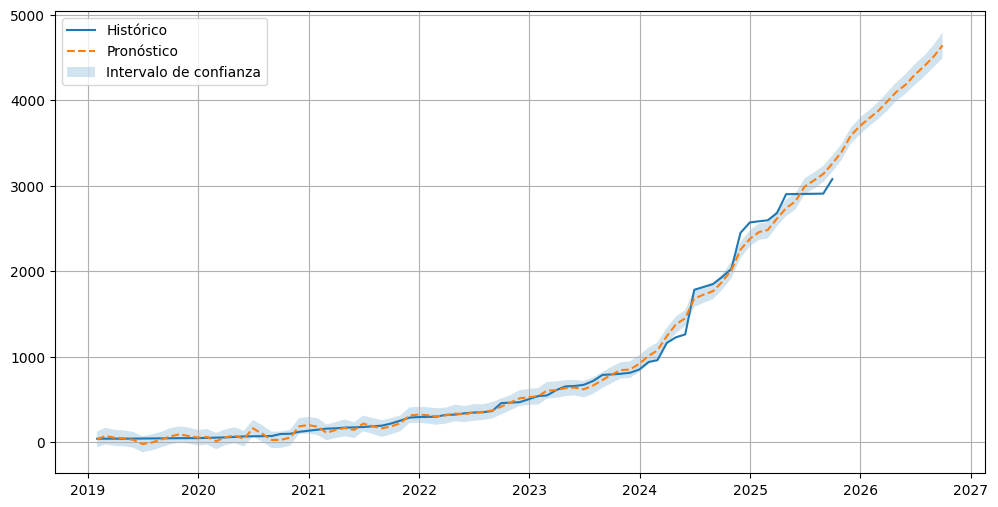

In [752]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(solar["ds"], solar["y"], label="Histórico")

ax.plot(forecast["ds"], forecast["yhat"], label="Pronóstico", linestyle="--")
ax.fill_between(
    forecast["ds"],
    forecast["yhat_lower"],
    forecast["yhat_upper"],
    alpha=0.2,
    label="Intervalo de confianza",
)

ax.legend()
ax.grid(True)
plt.show()


## **CONCLUSIONES**

El modelo ETS con configuración trend = 'add', seasonal = 'mul', seasonal_periods = 6 y damped_trend = False, evaluado mediante validación con ventana recursiva (expanding window), obtuvo el mejor desempeño entre todas las configuraciones probadas. Bajo este esquema, el modelo alcanzó un RMSE de 193.84, lo que indica una capacidad predictiva sólida para capturar tanto la tendencia creciente como la estacionalidad multiplicativa presente en la serie. Este resultado sugiere que la combinación de una tendencia aditiva con una dinámica estacional multiplicativa a seis periodos se ajusta de manera especialmente adecuada al comportamiento de la capacidad solar analizada, logrando proyecciones estables y consistentes en los distintos cortes temporales evaluados.